In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tabulate import tabulate

In [32]:
my_metrics = pd.read_csv("ml_intro_my_metrics.csv").set_index("element_id")
time_metrics = pd.read_csv("time_metrics.csv").set_index("id")

In [33]:
df = my_metrics.merge(time_metrics, left_index=True, right_index=True)
df = df.drop(columns="Unnamed: 0")
df

,mean_tries_count,tries_std,skips_percentage,lost_percentage,guessed_percentage,median_time,mean_time,median_dev,mean_dev
element_id,,,,,,,,,
22099,1.617647,1.859923,0.025043,NaN,0.010695,0.0,0.715903,0.0,-0.607019
22100,1.244648,1.730658,0.027610,0.012097,0.003058,0.0,0.223445,0.0,-1.117496
22101,1.140187,0.609025,0.006040,0.012245,0.000000,0.0,0.071072,0.0,-1.267508
22102,1.256250,1.207328,0.004303,0.010309,0.006250,0.0,0.356130,0.0,-0.990905
22110,2.324517,3.844413,0.042656,NaN,0.011190,0.0,1.173044,0.0,0.885897
...,...,...,...,...,...,...,...,...,...
34797,2.142968,2.503602,0.047573,NaN,0.005410,0.0,1.178034,0.0,0.824956
34799,1.254967,0.861443,0.111852,0.594918,0.000000,0.0,0.603873,0.0,-0.191132
34885,2.140244,2.655905,0.029412,0.309524,0.000000,0.0,2.805795,0.0,0.940015


#### Метрика времени

<Axes: xlabel='median_time', ylabel='Count'>

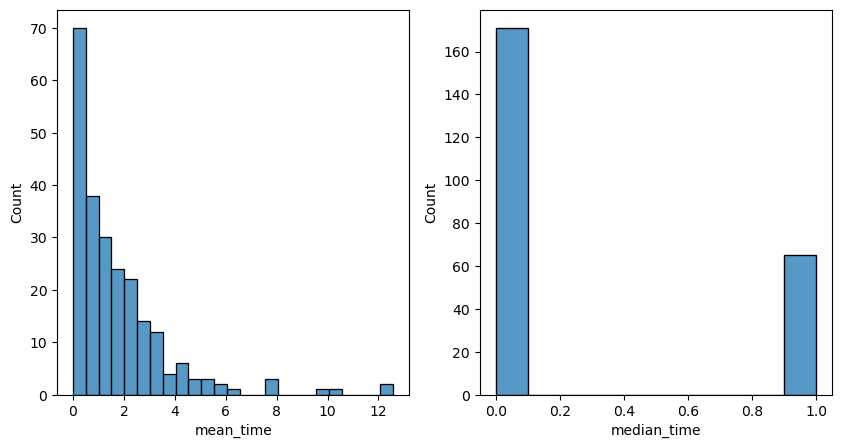

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df["mean_time"], binwidth=0.5, ax=ax[0])
sns.histplot(df["median_time"] > 0, binwidth=0.1, ax=ax[1])

In [35]:
# оставим только средние

df = df.drop(columns=["median_time", "median_dev"])

In [36]:
mean_time_threshold = 3.5

difficult_percentage = np.count_nonzero(df["mean_time"] > mean_time_threshold) / len(
    df["mean_time"]
)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

11.02 % задач мы считаем сложными


<Axes: xlabel='mean_dev', ylabel='Count'>

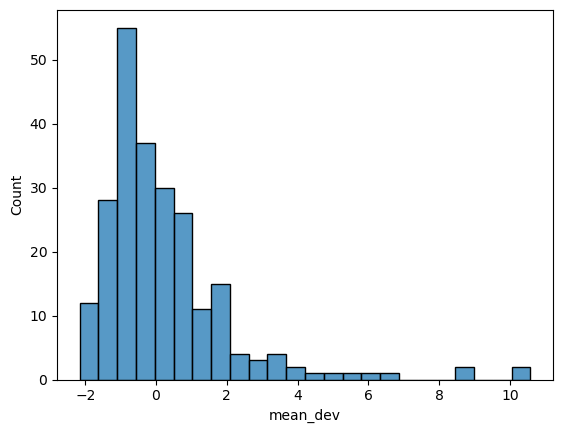

In [37]:
sns.histplot(df["mean_dev"])

In [38]:
mean_dev_threshold = 2

difficult_percentage = np.count_nonzero(df["mean_dev"] > mean_dev_threshold) / len(
    df["mean_dev"]
)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

9.75 % задач мы считаем сложными


## Связи метрик

### Анализ линейных зависимостей

In [40]:
mean_tries_threshold = 4
tries_std_threshold = 5
skips_percentage_threshold = 0.2
lost_percentage_threshold = 0.15
guessed_percentage_threshold = 0.2

In [41]:
thresholds = {
    "mean_tries_count": mean_tries_threshold,
    "tries_std": tries_std_threshold,
    "skips_percentage": skips_percentage_threshold,
    "lost_percentage": lost_percentage_threshold,
    "guessed_percentage": guessed_percentage_threshold,
    "mean_time": mean_time_threshold,
    "mean_dev": mean_dev_threshold,
}

In [134]:
def study_correlation(df, x_name, y_name, nonlinear=False, mi_df=None):
    print(f"Metrics: {x_name}, {y_name}")
    x = df[x_name]
    y = df[y_name]
    x_critical = thresholds[x_name]
    y_critical = thresholds[y_name]

    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, ax=ax)
    plt.axhline(y=y_critical, color="g")
    plt.axvline(x=x_critical, color="g")
    plt.xlabel(x_name)
    plt.ylabel(y_name)

    if nonlinear:
        print(f"Mutual information = {mi_df.loc[x_name, y_name]}")
    else:
        print(f"Pearson correlation coefficient = {x.corr(y)}")
    print("Amount by segments:")
    left_up = len(df[(df[x_name] <= x_critical) & (df[y_name] > y_critical)])
    left_down = len(df[(df[x_name] <= x_critical) & (df[y_name] <= y_critical)])
    right_up = len(df[(df[x_name] > x_critical) & (df[y_name] > y_critical)])
    right_down = len(df[(df[x_name] > x_critical) & (df[y_name] <= y_critical)])
    print(
        tabulate([[left_up, right_up], [left_down, right_down]], tablefmt="fancy_grid")
    )

<Axes: >

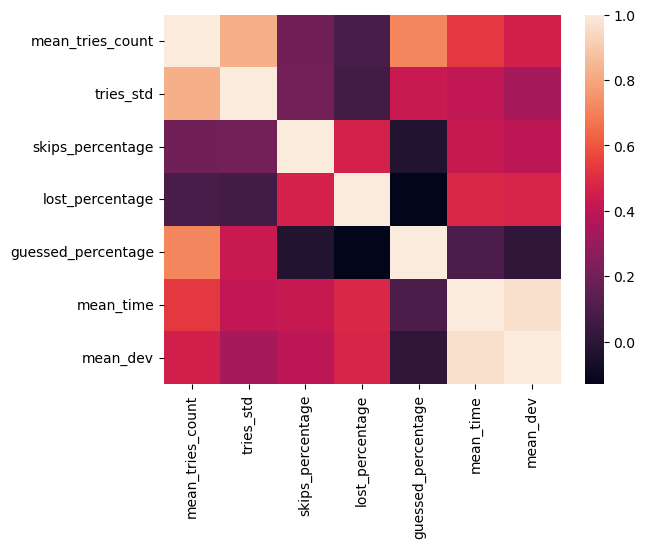

In [43]:
sns.heatmap(df.corr())

Посмотрим на наиболее сильные линейные зависимости.

##### mean_time, mean_dev

Metrics: mean_time, mean_dev
Pearson correlation coefficient = 0.9656036322235833
Amount by segments:
╒═════╤════╕
│   1 │ 22 │
├─────┼────┤
│ 209 │  4 │
╘═════╧════╛


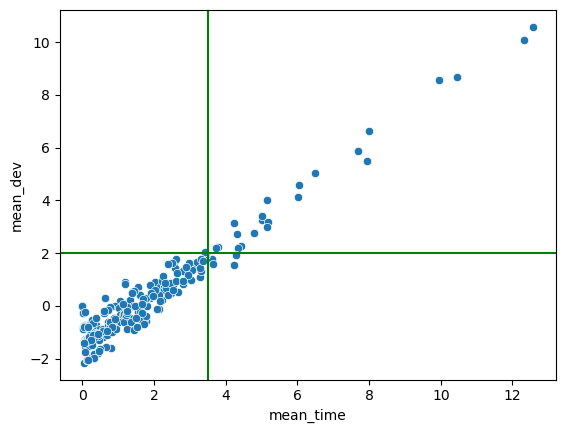

In [45]:
study_correlation(df, "mean_time", "mean_dev")

Эта корреляция очень сильная - оставлять обе метрики не имеет смысла. Оставим `mean_time` как более интерпретируемую.

In [46]:
df = df.drop(columns="mean_dev")

##### mean_tries_count, tries_std

Metrics: mean_tries_count, tries_std
Pearson correlation coefficient = 0.8249094898423509
Amount by segments:
╒═════╤════╕
│  18 │ 42 │
├─────┼────┤
│ 172 │  4 │
╘═════╧════╛


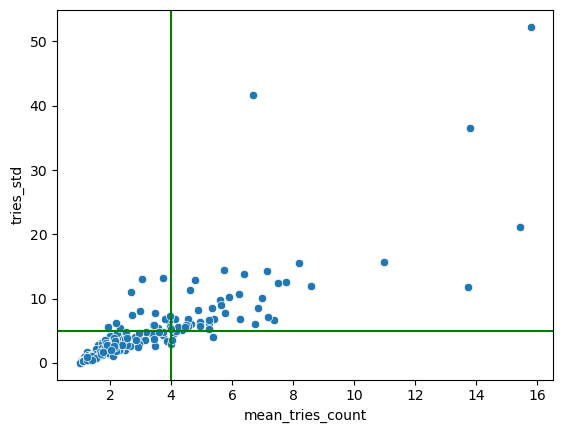

In [131]:
study_correlation(df, "mean_tries_count", "tries_std")

Зависимость сильная, но есть значительное (в рамках данного курса) количество задач, сложных только по `tries_std`. Стоит посмотреть на эти задачи/взаимосвязь этих метрик на выборке побольше.

##### mean_tries_count, guessed_percentage

Metrics: mean_tries_count, guessed_percentage
Pearson correlation coefficient = 0.713984918686307
Amount by segments:
╒═════╤════╕
│   1 │ 10 │
├─────┼────┤
│ 189 │ 36 │
╘═════╧════╛


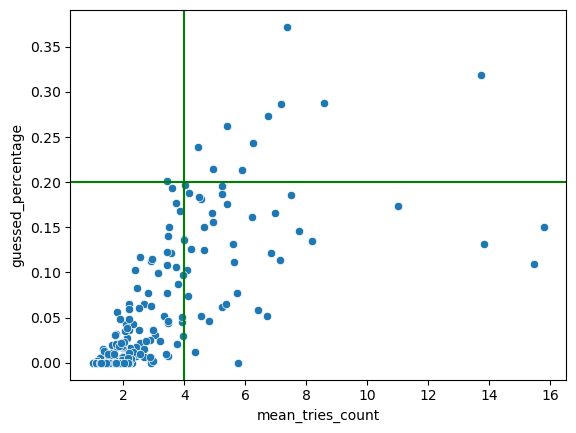

In [49]:
study_correlation(df, "mean_tries_count", "guessed_percentage")

То, что слева вверху пусто - логично, так как если было много угадываний, то и попыток в среднем было много. Но в обратную сторону это не работает: много сделать много вдумчивых попыток на слодную задачу. Поэтому исключать какую-то из этих метрик не стоит - они показывают разные виды сложности.

##### mean_tries_count, mean_time

Metrics: mean_tries_count, mean_time
Pearson correlation coefficient = 0.5275509618252006
Amount by segments:
╒═════╤════╕
│  12 │ 14 │
├─────┼────┤
│ 178 │ 32 │
╘═════╧════╛


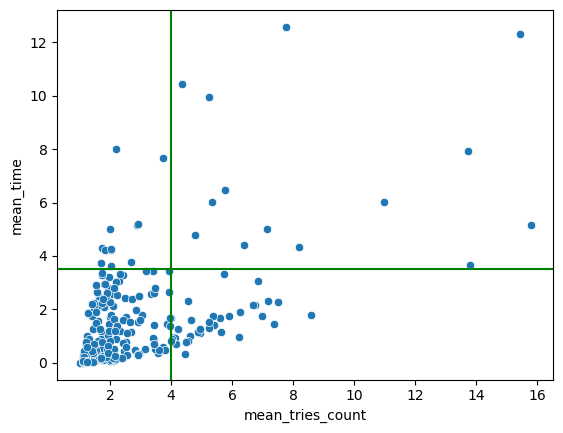

In [50]:
study_correlation(df, "mean_tries_count", "mean_time")

### Нелинейные зависимости

Идея: если метрики нелинейно связаны, это хорошо, потому что тогда они показывают различные виды сложности, но при этом коррелируют.

In [167]:
from sklearn.feature_selection import mutual_info_regression

df_no_nan = df
df_no_nan["lost_percentage"] = df["lost_percentage"].fillna(0)
mask = np.ones(shape=(len(metrics_list), len(metrics_list)))
metrics_list = df_no_nan.columns
mi_df = pd.DataFrame(columns=metrics_list, index=metrics_list)
hard_mi_df = pd.DataFrame(columns=metrics_list, index=metrics_list)
for i, y_name in enumerate(metrics_list):
    for j in range(0, i):
        x_name = metrics_list[j]
        mi_score = mutual_info_regression(df_no_nan[[x_name]], df_no_nan[y_name])[0]
        mask[j][i] = 0
        mi_df.loc[x_name, y_name] = float(mi_score)
        hard_df = df_no_nan[
            (df_no_nan[x_name] > thresholds[x_name])
            | (df_no_nan[y_name] > thresholds[y_name])
        ]
        hard_mi_score = mutual_info_regression(hard_df[[x_name]], hard_df[y_name])[0]
        hard_mi_df.loc[x_name, y_name] = float(hard_mi_score)

In [172]:
hard_mi_df = hard_mi_df.fillna(0.0)

In [168]:
mi_df = mi_df.fillna(0.0)

<Axes: >

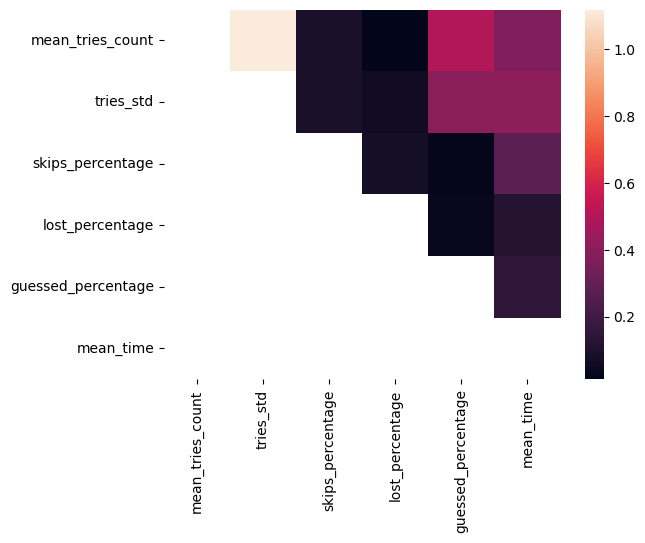

In [169]:
sns.heatmap(mi_df, mask=mask)

<Axes: >

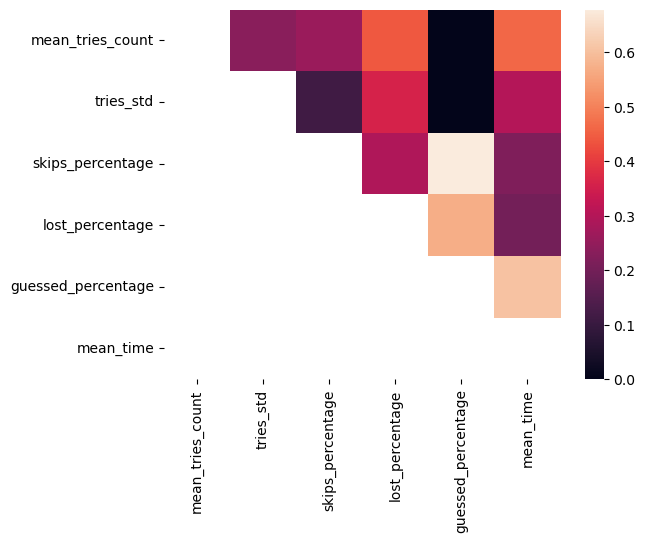

In [173]:
sns.heatmap(hard_mi_df, mask=mask)

Metrics: tries_std, skips_percentage
Mutual information = 0.09049598342117537
Amount by segments:
╒═════╤════╕
│  12 │  5 │
├─────┼────┤
│ 164 │ 55 │
╘═════╧════╛


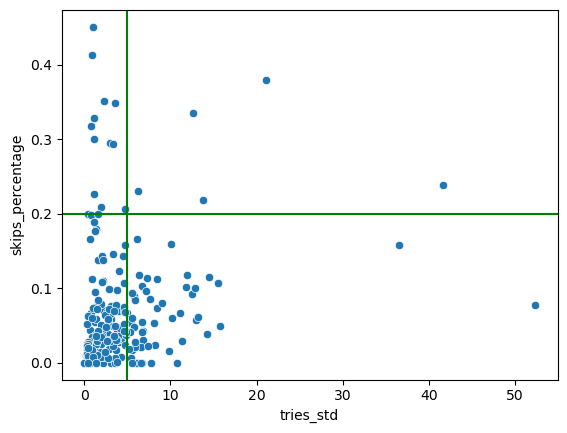

In [161]:
study_correlation(df, "tries_std", "skips_percentage", nonlinear=True, mi_df=mi_df)

<Axes: xlabel='skips_percentage', ylabel='tries_std'>

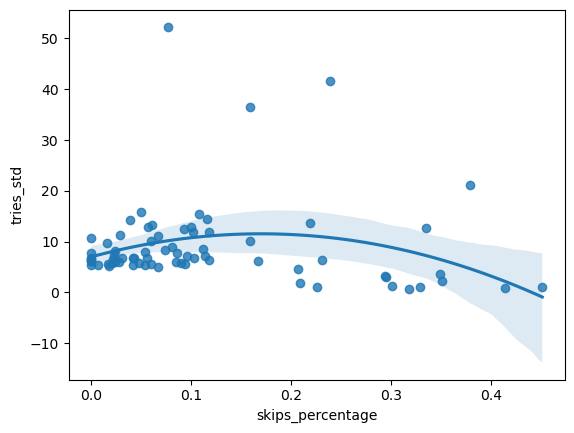

In [163]:
hard_df = df[
    (df["skips_percentage"] > thresholds["skips_percentage"])
    | (df["tries_std"] > thresholds["tries_std"])
]
sns.regplot(data=hard_df, x="skips_percentage", y="tries_std", order=2)

Metrics: skips_percentage, guessed_percentage
Mutual information = 0.02402817624661724
Amount by segments:
╒═════╤════╕
│  11 │  0 │
├─────┼────┤
│ 208 │ 17 │
╘═════╧════╛


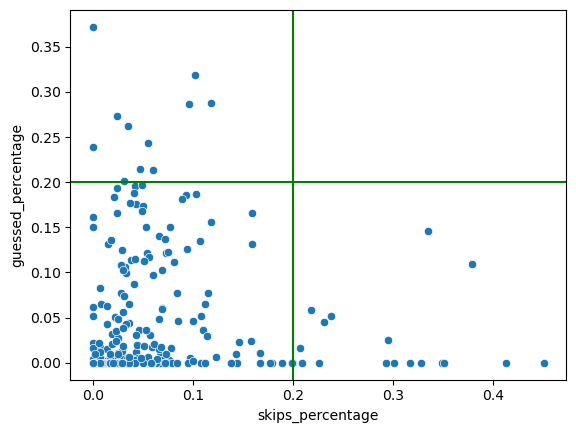

In [175]:
study_correlation(
    df, "skips_percentage", "guessed_percentage", nonlinear=True, mi_df=mi_df
)

<Axes: xlabel='skips_percentage', ylabel='guessed_percentage'>

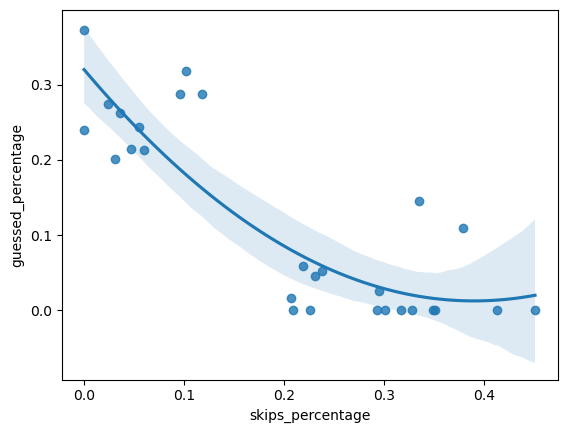

In [174]:
hard_df = df[
    (df["skips_percentage"] > thresholds["skips_percentage"])
    | (df["guessed_percentage"] > thresholds["guessed_percentage"])
]
sns.regplot(data=hard_df, x="skips_percentage", y="guessed_percentage", order=2)

Metrics: skips_percentage, mean_time
Mutual information = 0.2749971725896496
Amount by segments:
╒═════╤═══╕
│  18 │ 8 │
├─────┼───┤
│ 201 │ 9 │
╘═════╧═══╛


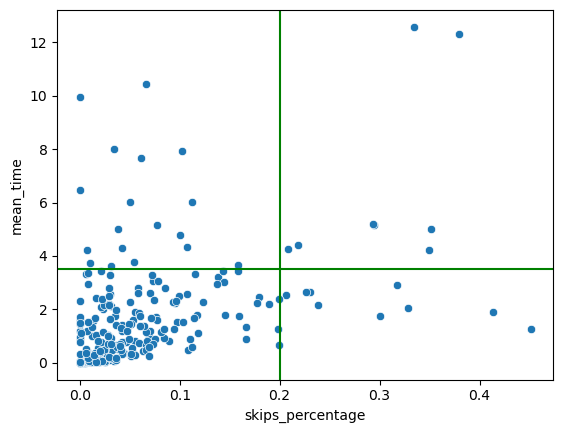

In [164]:
study_correlation(df, "skips_percentage", "mean_time", nonlinear=True, mi_df=mi_df)

<Axes: xlabel='skips_percentage', ylabel='mean_time'>

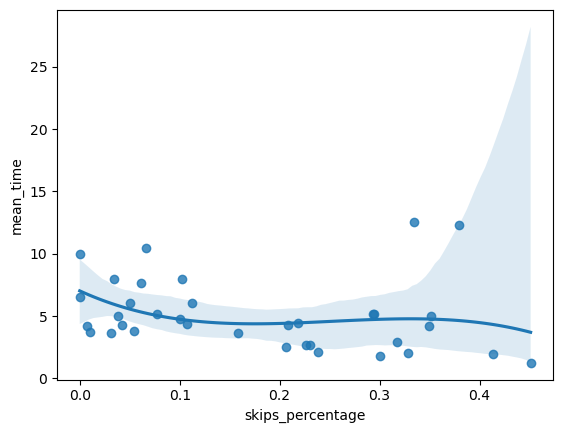

In [166]:
hard_df = df[
    (df["skips_percentage"] > thresholds["skips_percentage"])
    | (df["mean_time"] > thresholds["mean_time"])
]
sns.regplot(data=hard_df, x="skips_percentage", y="mean_time", order=3)

### Подсчет числа сложных задач

In [179]:
df_hard = pd.DataFrame(index=df.index)
sum = pd.Series([0] * len(df_hard.index), index=df_hard.index)
for metric in df.columns:
    df_hard[metric] = df[metric] >= thresholds[metric]
    sum += df_hard[metric].astype(int)
df_hard["hard_count"] = sum
df_hard

,mean_tries_count,tries_std,skips_percentage,lost_percentage,guessed_percentage,mean_time,hard_count
element_id,,,,,,,
22099,False,False,False,False,False,False,0
22100,False,False,False,False,False,False,0
22101,False,False,False,False,False,False,0
22102,False,False,False,False,False,False,0
22110,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...
34797,False,False,False,False,False,False,0
34799,False,False,False,True,False,False,1
34885,False,False,False,True,False,False,1


<Axes: ylabel='Count'>

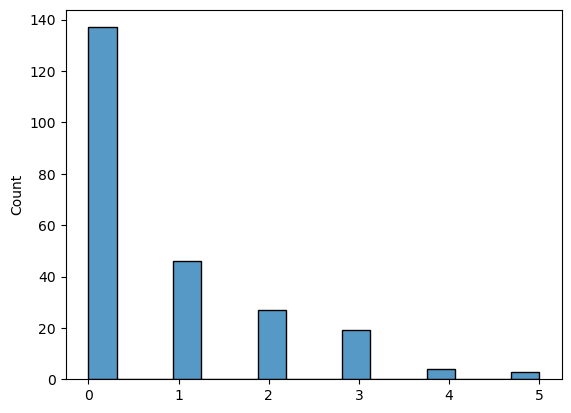

In [180]:
sns.histplot(sum)

In [181]:
# количество сложных только по lost_percentage
len(
    df_hard[
        (df_hard["lost_percentage"])
        & (~df_hard["mean_tries_count"])
        & (
            ~df_hard["tries_std"]
            & (~df_hard["skips_percentage"])
            & (~df_hard["guessed_percentage"])
        )
    ]
)

17

Но у lost_percentage был один из самых легких трэшхолодов.

In [184]:
quantile_10 = {}
for metric in df.columns:
    quantile_10[metric] = df[metric].quantile(q=0.9)

In [185]:
quantile_10

{'mean_tries_count': 5.506317652385068,
 'tries_std': 8.457179863292705,
 'skips_percentage': 0.1666666666666666,
 'lost_percentage': 0.17198183906788467,
 'guessed_percentage': 0.16566232257596103,
 'mean_time': 3.691619526469109}

In [187]:
df_hard = pd.DataFrame(index=df.index)
sum = pd.Series([0] * len(df_hard.index), index=df_hard.index)
for metric in df.columns:
    df_hard[metric] = df[metric] >= quantile_10[metric]
    sum += df_hard[metric].astype(int)
df_hard["hard_count"] = sum
df_hard

,mean_tries_count,tries_std,skips_percentage,lost_percentage,guessed_percentage,mean_time,hard_count
element_id,,,,,,,
22099,False,False,False,False,False,False,0
22100,False,False,False,False,False,False,0
22101,False,False,False,False,False,False,0
22102,False,False,False,False,False,False,0
22110,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...
34797,False,False,False,False,False,False,0
34799,False,False,False,True,False,False,1
34885,False,False,False,True,False,False,1


<Axes: ylabel='Count'>

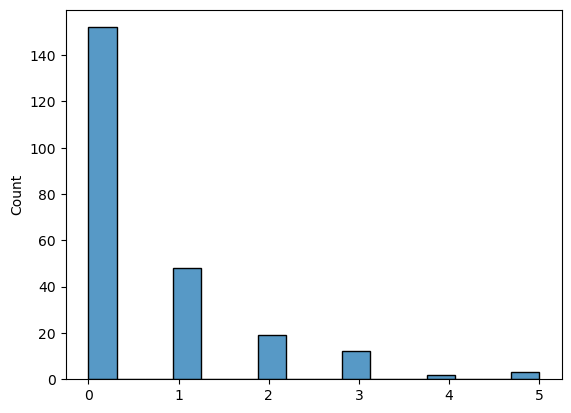

In [188]:
sns.histplot(sum)

In [189]:
# количество сложных только по lost_percentage
len(
    df_hard[
        (df_hard["lost_percentage"])
        & (~df_hard["mean_tries_count"])
        & (
            ~df_hard["tries_std"]
            & (~df_hard["skips_percentage"])
            & (~df_hard["guessed_percentage"])
        )
    ]
)

13

In [190]:
# количество сложных только по skips_percentage
len(
    df_hard[
        (df_hard["skips_percentage"])
        & (~df_hard["mean_tries_count"])
        & (
            ~df_hard["tries_std"]
            & (~df_hard["lost_percentage"])
            & (~df_hard["guessed_percentage"])
        )
    ]
)

15

In [191]:
# количество сложных только по guessed_percentage
len(
    df_hard[
        (df_hard["guessed_percentage"])
        & (~df_hard["mean_tries_count"])
        & (
            ~df_hard["tries_std"]
            & (~df_hard["skips_percentage"])
            & (~df_hard["lost_percentage"])
        )
    ]
)

15

## Кластеризация

In [196]:
# заполним 0: незаполненные значения - начало новой темы
df_cluster = df
df_cluster["lost_percentage"] = df_cluster["lost_percentage"].fillna(0)

### KMeans

In [197]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_cluster = scaler.fit_transform(df_cluster)

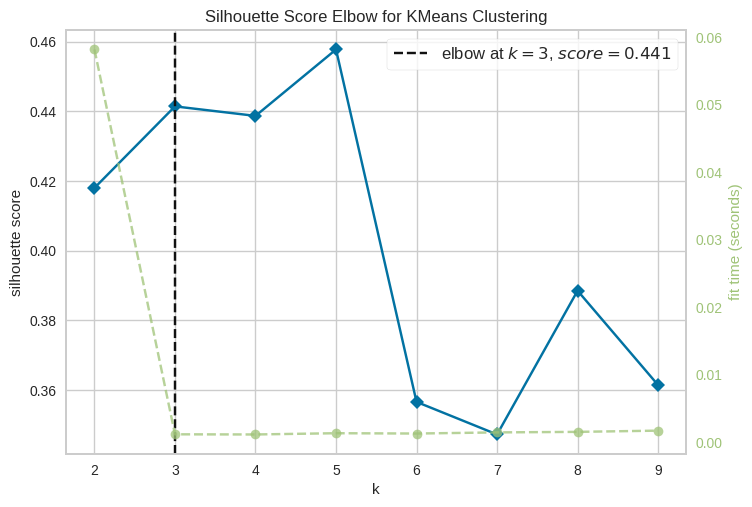

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [198]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 10), metric="silhouette", random_state=42)

visualizer.fit(data_cluster)
visualizer.show()

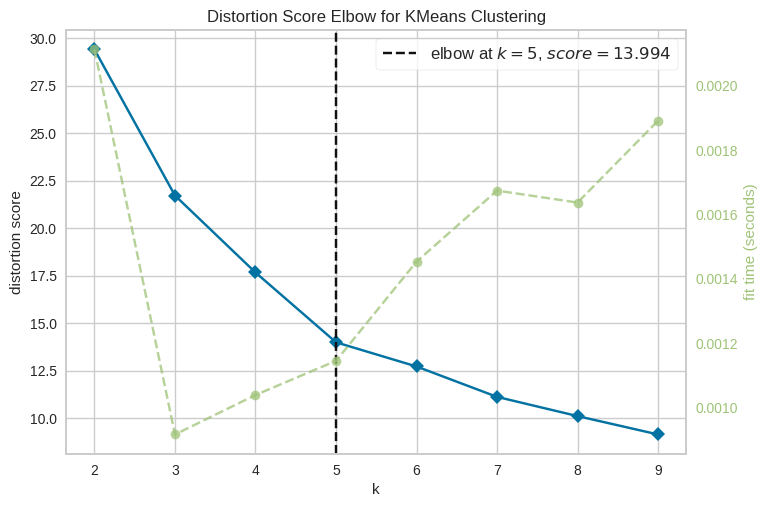

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [199]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 10), random_state=42)

visualizer.fit(data_cluster)
visualizer.show()

In [200]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(data_cluster)

In [201]:
df_cluster["cluster"] = clusters

In [202]:
df_cluster

,mean_tries_count,tries_std,skips_percentage,lost_percentage,guessed_percentage,mean_time,cluster
element_id,,,,,,,
22099,1.617647,1.859923,0.025043,0.000000,0.010695,0.715903,2
22100,1.244648,1.730658,0.027610,0.012097,0.003058,0.223445,2
22101,1.140187,0.609025,0.006040,0.012245,0.000000,0.071072,2
22102,1.256250,1.207328,0.004303,0.010309,0.006250,0.356130,2
22110,2.324517,3.844413,0.042656,0.000000,0.011190,1.173044,2
...,...,...,...,...,...,...,...
34797,2.142968,2.503602,0.047573,0.000000,0.005410,1.178034,2
34799,1.254967,0.861443,0.111852,0.594918,0.000000,0.603873,1
34885,2.140244,2.655905,0.029412,0.309524,0.000000,2.805795,1


In [203]:
pd.Series(kmeans.labels_).value_counts()

2    148
0     47
1     41
Name: count, dtype: int64

In [204]:
df_cluster.groupby("cluster").mean()

,mean_tries_count,tries_std,skips_percentage,lost_percentage,guessed_percentage,mean_time
cluster,,,,,,
0,5.953712,9.708968,0.062633,0.025731,0.173749,2.035774
1,2.945055,4.258893,0.174079,0.243438,0.015577,3.871887
2,1.971369,2.384113,0.039070,0.024299,0.019118,1.016998


In [205]:
df_cluster.groupby("cluster").median()

,mean_tries_count,tries_std,skips_percentage,lost_percentage,guessed_percentage,mean_time
cluster,,,,,,
0,5.230769,6.338745,0.052632,0.005319,0.16568,1.446417
1,2.028112,2.310725,0.145695,0.223176,0.00000,2.897429
2,1.802594,1.801219,0.029136,0.006697,0.00447,0.640824
